# Description

We will use the preprocessed rossman data and compare regression accuracies/errors for tabnet and node vs XGBoost

In [3]:
!pip install pytorch_tabnet
!pip install xgboost

In [4]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
data = pd.read_csv('preprocessed_data.csv', index_col=0)
data = data.iloc[:10000, :] #data was too big for node
display(data)
X, y = data.drop(columns='Sales'), data[['Sales']]

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Store,Customers,CompetitionDistance,Promo,Promo2,StateHoliday,StoreType,Assortment,AvgSales,AvgCustomers,AvgSalesPerCustomer,MedSales,MedCustomers,MedSalesPerCustomer,DayOfWeek,Week,Day,Month,Year,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear,Sales
0,1,555,1270.0,1,0,1,2,0,3945.704883,467.646497,8.393038,4373.5,529.0,8.362376,5,31,31,7,2015,9,2008,0,0,5263
1,2,625,570.0,1,1,1,0,0,4122.991507,486.045648,8.408443,4395.5,542.0,8.313092,5,31,31,7,2015,11,2007,13,2010,6064
2,3,821,14130.0,1,1,1,0,0,5741.253715,620.286624,9.117599,5892.0,705.0,9.123440,5,31,31,7,2015,12,2006,14,2011,8314
3,4,1498,620.0,1,0,1,2,2,8021.769639,1100.057325,7.249827,9062.0,1261.5,7.215175,5,31,31,7,2015,9,2009,0,0,13995
4,5,559,29910.0,1,0,1,0,0,3867.110403,444.360934,8.611229,4180.0,537.0,8.584677,5,31,31,7,2015,4,2015,0,0,4822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1076,445,90.0,0,1,1,0,2,2993.630573,451.066879,6.564141,3202.5,505.5,6.476654,4,30,23,7,2015,0,0,1,2013,2994
9996,1077,369,3750.0,0,1,1,0,0,3712.875796,410.124204,8.943172,3892.0,470.0,8.816291,4,30,23,7,2015,11,2001,35,2010,3215
9997,1078,539,670.0,0,1,1,3,2,5615.581741,431.910828,12.758756,5639.5,469.0,12.559140,4,30,23,7,2015,0,0,40,2011,6938
9998,1079,651,16680.0,0,1,1,0,0,7200.880042,571.511677,12.419482,7228.5,619.0,12.229572,4,30,23,7,2015,0,0,37,2009,7513


### Baseline Model: XGBoost

In [5]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

model = XGBRegressor(n_estimators=1000)

#fit
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          early_stopping_rounds=7000,
          verbose=10,
          eval_metric=['logloss', 'rmse'])

#pred
pred = model.predict(X_test)

#evaluation
rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))

[03:18:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-logloss:-244810	validation_0-rmse:6895.42	validation_1-logloss:-247552	validation_1-rmse:6974.55
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 7000 rounds.
[10]	validation_0-logloss:-244810	validation_0-rmse:2674.62	validation_1-logloss:-247548	validation_1-rmse:2735.83
[20]	validation_0-logloss:-244810	validation_0-rmse:1278.22	validation_1-logloss:-247548	validation_1-rmse:1333.65
[30]	validation_0-logloss:-244810	validation_0-rmse:838.495	validation_1-logloss:-247548	validation_1-rmse:889.522
[40]	validation_0-logloss:-244810	validation_0-rmse:674.998	validation_1-logloss:-247548	validation_1-rmse:728.446
[50]	validation_0-logloss:-244810	validation_0-rmse:600.055	validation_1-logloss:-247548	validation_1-rmse:653.382
[60]	validation_0-loglo

In [6]:
xgb_boost_losses = pd.concat([pd.Series(model.evals_result()['validation_0']['logloss']), pd.Series(model.evals_result()['validation_1']['logloss'])], keys=['Train NLL (XGB)', 'Test NLL (XGB)'], axis=1)
xgb_boost_errors = pd.concat([1 - pd.Series(model.evals_result()['validation_0']['rmse']), 1 - pd.Series(model.evals_result()['validation_1']['rmse'])], keys=['Train RMSE (XGB)', 'Test RMSE (XGB)'], axis=1)

display(xgb_boost_losses)
display(xgb_boost_errors)

xgb_boost_losses.to_csv('xgb_losses.csv')
xgb_boost_errors.to_csv('xgb_errors.csv')

,Train NLL (XGB),Test NLL (XGB)
0,-244810.500000,-247551.796875
1,-244810.515625,-247551.765625
2,-244809.765625,-247547.890625
3,-244809.765625,-247547.890625
4,-244809.765625,-247547.890625
...,...,...
995,-244811.656250,-247549.875000
996,-244811.656250,-247549.875000
997,-244811.656250,-247549.875000
998,-244811.656250,-247549.875000


,Train RMSE (XGB),Test RMSE (XGB)
0,-6894.423828,-6973.551270
1,-6245.073242,-6322.182129
2,-5659.668457,-5732.995117
3,-5132.951660,-5205.038574
4,-4663.282715,-4730.944336
...,...,...
995,-292.169800,-438.639313
996,-292.135834,-438.629486
997,-292.132690,-438.628967
998,-292.099335,-438.561371


### TabNet

In [7]:
from pytorch_tabnet.tab_model import TabNetRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

model = TabNetRegressor(n_a=32, n_d=32, lambda_sparse=0.001, n_steps=5, gamma=1.2)  #TabNetRegressor()

model.fit( 
    X_train.to_numpy(), y_train.to_numpy(),
    eval_set=[(X_train.to_numpy(), y_train.to_numpy()), (X_test.to_numpy(), y_test.to_numpy())],
    eval_metric=['rmse'],
    max_epochs = 1000,
    batch_size = 4096,
    virtual_batch_size = 512,
    patience = 0 #Remove stopping criteria

)

Device used : cuda
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 58392143.52| val_0_rmse: 7466.53677| val_1_rmse: 7514.16153|  0:00:00s
epoch 1  | loss: 58328082.88| val_0_rmse: 4316.33003| val_1_rmse: 4376.11194|  0:00:00s
epoch 2  | loss: 58265871.04| val_0_rmse: 4619.81177| val_1_rmse: 4638.9081|  0:00:01s
epoch 3  | loss: 58197798.72| val_0_rmse: 7254.27095| val_1_rmse: 7243.31773|  0:00:01s
epoch 4  | loss: 58124346.88| val_0_rmse: 8471.67494| val_1_rmse: 8350.45101|  0:00:01s
epoch 5  | loss: 58044396.32| val_0_rmse: 8852.08525| val_1_rmse: 8742.25329|  0:00:02s
epoch 6  | loss: 57954137.12| val_0_rmse: 8805.2323| val_1_rmse: 8666.06593|  0:00:02s
epoch 7  | loss: 57857267.2| val_0_rmse: 8415.91431| val_1_rmse: 8257.37089|  0:00:02s
epoch 8  | loss: 57760278.56| val_0_rmse: 8447.62261| val_1_rmse: 8399.37203|  0:00:02s
epoch 9  | loss: 57651958.08| val_0_rmse: 9088.20583| val_1_rmse: 9057.37126|  0:00:03s
epoch 10 | loss: 57526504.8| va

In [8]:
preds = model.predict(X_test.to_numpy())
rmse = np.sqrt(MSE(y_test, preds))
print("RMSE : % f" %(rmse))

RMSE :  526.682701


In [9]:
tabnet_errors = pd.concat([pd.Series(model.history['val_0_rmse']), pd.Series(model.history['val_1_rmse'])], keys=['Train RMSE (TabNet)', 'Test RMSE (TabNet)'], axis=1)

display(tabnet_errors)

tabnet_errors.to_csv('tabnet_errors.csv') 

,Train RMSE (TabNet),Test RMSE (TabNet)
0,7466.536772,7514.161535
1,4316.330034,4376.111939
2,4619.811766,4638.908104
3,7254.270951,7243.317726
4,8471.674944,8350.451013
...,...,...
995,304.755790,496.552460
996,298.565050,501.079640
997,315.488545,501.117144
998,305.812117,500.072921


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 <a list of 23 Text major ticklabel objects>)

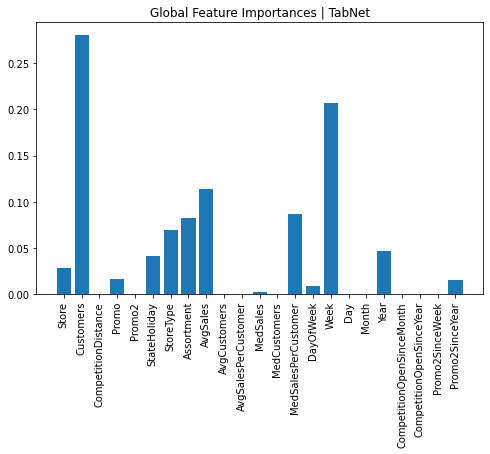

In [20]:
plt.figure(figsize = (8, 5))
plt.bar(x=[i for i in data.columns if i!='Sales'], height=model.feature_importances_)
plt.title('Global Feature Importances | TabNet')
plt.xticks(rotation=90)

In [18]:
model.feature_importances_.shape

(23,)

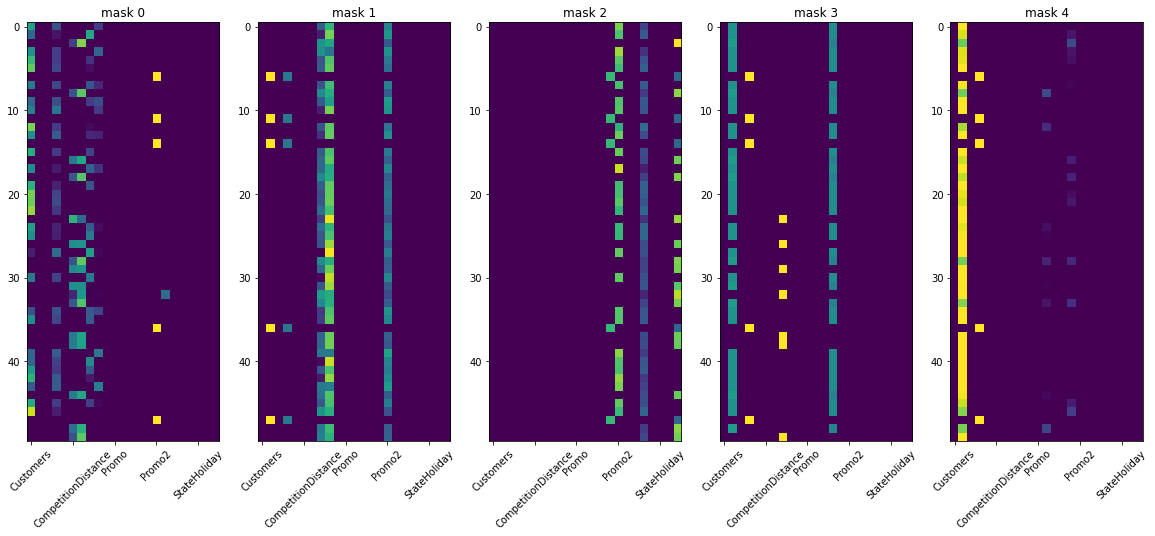

In [24]:
explain_matrix, masks = model.explain(X_test.to_numpy())
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticklabels([i for i in data.columns if i!='Sales'], rotation=45)

## NODE


#### Wont Run

In [ ]:
!git clone https://github.com/Qwicen/node.git

In [ ]:
!pip install -r node/requirements.txt

In [ ]:
from node import lib

from category_encoders import LeaveOneOutEncoder
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0
import os, sys
import time
sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [ ]:

in_features = X_train.shape[1]

model = nn.Sequential(
    lib.DenseBlock(in_features, 128, num_layers=8, tree_dim=3, depth=6, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)

'''
with torch.no_grad():
    tmp = torch.tensor(X_train[:5000].to_numpy(), device=device)
    #tmp = tmp.type(torch.int)
    res = model(tmp.int())
'''

In [ ]:
X_train.shape

In [ ]:
from qhoptim.pyt import QHAdam
optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }

In [ ]:
from tqdm import tqdm
from IPython.display import clear_output
loss_history, rmse_history = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 5000
report_frequency = 50

In [ ]:
trainer = lib.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name='xyz_200k32',
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

In [ ]:
X_train = torch.Tensor(X_train.to_numpy())
y_train = torch.Tensor(y_train.to_numpy())
X_valid = torch.Tensor(X_valid.to_numpy())
y_valid = torch.Tensor(y_valid.to_numpy())


for batch in lib.iterate_minibatches(X_train, y_train, batch_size=512, 
                                                shuffle=True, epochs=1000):
    metrics = trainer.train_on_batch(*batch, device=device)
    
    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            X_valid, y_valid, device=device, batch_size=16384)
        
        # loss_history.append(metrics['loss'])

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')

        rmse = np.sqrt(mse)
        rmse_history.append(rmse)
        
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()

        # clear_output(True)
        # plt.figure(figsize=[18, 6])
        # plt.subplot(1, 2, 1)
        # plt.plot(loss_history)
        # plt.title('Loss')
        # plt.grid()
        # plt.subplot(1, 2, 2)
        # plt.plot(rmse_history)
        # plt.title('MSE')
        # plt.grid()
        # plt.show()
        # print("Loss %.5f" % (metrics['loss']))
        print("Val Error: %0.5f" % (rmse))
    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Error: %0.5f" % (best_mse))
        break

In [ ]:
X_test = torch.Tensor(X_test.to_numpy())
y_test = torch.Tensor(y_test.to_numpy())

In [ ]:
trainer.load_checkpoint(tag='best_mse')
mse = trainer.evaluate_mse(X_test, y_test, device=device)
print('Best step: ', trainer.step)
print("Test RMSE: %0.5f" % (np.sqrt(mse)))